<a href="https://colab.research.google.com/github/NandaGoplalNaskar/Pytorch/blob/main/Physics_Informed_Neural_Network_for_LPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 1s/step - loss: 1.5478e-04
Epoch 2507/5000
1/1 [==============================] - 1s 1s/step - loss: 1.5473e-04
Epoch 2508/5000
1/1 [==============================] - 1s 1s/step - loss: 1.5468e-04
Epoch 2509/5000
1/1 [==============================] - 1s 1s/step - loss: 1.5464e-04
Epoch 2510/5000
1/1 [==============================] - 1s 1s/step - loss: 1.5459e-04
Epoch 2511/5000
1/1 [==============================] - 1s 1s/step - loss: 1.5454e-04
Epoch 2512/5000
1/1 [==============================] - 1s 1s/step - loss: 1.5449e-04
Epoch 2513/5000
1/1 [==============================] - 1s 1s/step - loss: 1.5444e-04
Epoch 2514/5000
1/1 [==============================] - 1s 1s/step - loss: 1.5439e-04
Epoch 2515/5000
1/1 [==============================] - 1s 1s/step - loss: 1.5435e-04
Epoch 2516/5000
1/1 [==============================] - 2s 2s/step - loss: 1.5430e-04
Epoch 2517/5000
1/1 [=========

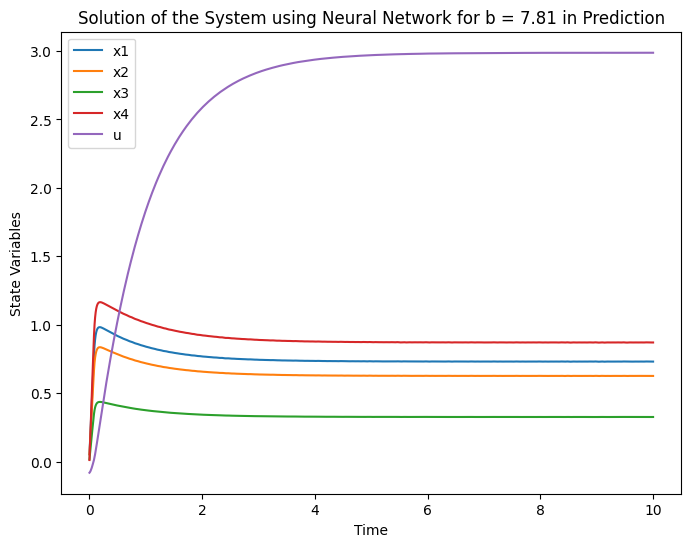

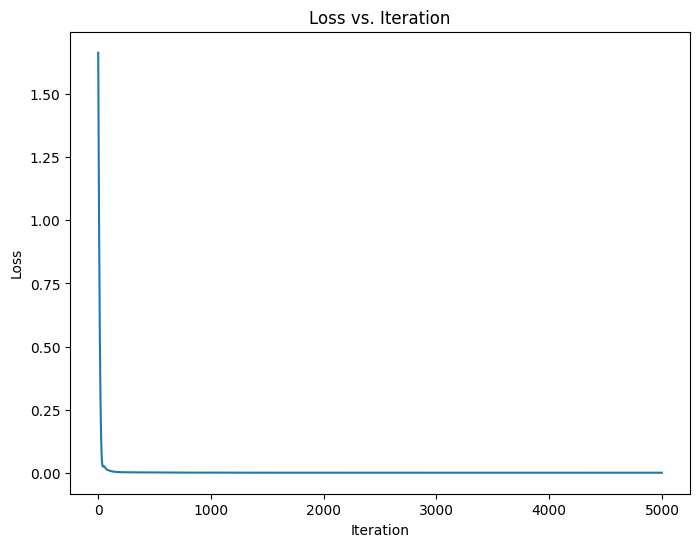

In [10]:
import numpy as np
from scipy.integrate import solve_ivp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define the system of differential equations with variable b
def system(t, y, b):
    x1, x2, x3, x4, u = y
    dydt = [
        -(-9.54 + max(3.18 * (u + 3.18 * x1 + 2.72 * x2 + 1.42 * x3 + 3.81 * x4 - b), 0)),
        -(-8.16 + max(2.72 * (u + 3.18 * x1 + 2.72 * x2 + 1.42 * x3 + 3.81 * x4 - b), 0)),
        -(-4.26 + max(1.42 * (u + 3.18 * x1 + 2.72 * x2 + 1.42 * x3 + 3.81 * x4 - b), 0)),
        -(-11.43 + max(3.81 * (u + 3.18 * x1 + 2.72 * x2 + 1.42 * x3 + 3.81 * x4 - b), 0)),
        max((u + 3.18 * x1 + 2.72 * x2 + 1.42 * x3 + 3.81 * x4 - b), 0) - u
    ]
    return dydt

# Function to generate data with a probability distribution for b
def generate_data(num_samples, mean_b, std_dev_b, is_training=True):
    # Set initial conditions and time span
    initial_condition = [0, 0, 0, 0, 0]
    t_span = (0, 10)

    # Generate random values of b from a normal distribution
    b_values = np.random.normal(loc=mean_b, scale=std_dev_b, size=num_samples)

    # Initialize arrays to store data
    X_data = []
    y_data = []

    for b_value in b_values:
        # Generate data using solve_ivp
        sol = solve_ivp(system, t_span, initial_condition, args=(b_value,), method='RK45', dense_output=True)
        t_values = np.linspace(0, 10, 1000)
        y_values = sol.sol(t_values)

        # Extract the input (X_data) and target (y_data) data
        X_data.append(y_values.T[:-1, :])  # Use states as input
        y_data.append(y_values.T[1:, :])    # Use derivatives as target

    X_data = np.vstack(X_data)
    y_data = np.vstack(y_data)

    return X_data, y_data

# Define the neural network architecture with two hidden layers
model = Sequential([
    Dense(100, activation='tanh', input_shape=(5,)),
    Dense(5)  # Output layer with 5 nodes for derivatives
])

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Generate training data with a probability distribution for b
num_samples_train = 1000
mean_b_train = 5.0
std_dev_b_train = 2.0
X_train, y_train = generate_data(num_samples_train, mean_b_train, std_dev_b_train)

# Train the model
history = model.fit(X_train, y_train, epochs=5000, batch_size=len(X_train), verbose=1)

# Generate testing data with a probability distribution for b
num_samples_test = 500
mean_b_test = 5.0  # You can change this value
std_dev_b_test = 2.0  # You can change this value
X_test, y_test = generate_data(num_samples_test, mean_b_test, std_dev_b_test, is_training=False)

# Evaluate the model on the testing data
test_loss = model.evaluate(X_test, y_test)
print(f"\nTest Loss for b distribution: {test_loss}")

# Make predictions for b = 7.81
b_value_to_predict = 7.81
X_predict, y_predict = generate_data(1, b_value_to_predict, 0, is_training=False)

# Use the trained model to predict the system's response
predicted_states = model.predict(X_predict)

# Print the final values for the predicted b value
final_values_predict = predicted_states[-1]
print(f"\nFinal values for b={b_value_to_predict:.2f} in prediction:")
print(f"x1: {final_values_predict[0]}")
print(f"x2: {final_values_predict[1]}")
print(f"x3: {final_values_predict[2]}")
print(f"x4: {final_values_predict[3]}")
print(f"u: {final_values_predict[4]}")

# Plot the results for the predicted b value
t_values_visualize = np.linspace(0, 10, 999)  # Adjust the length to match the data
plt.figure(figsize=(8, 6))
plt.plot(t_values_visualize, predicted_states[:, 0], label='x1')
plt.plot(t_values_visualize, predicted_states[:, 1], label='x2')
plt.plot(t_values_visualize, predicted_states[:, 2], label='x3')
plt.plot(t_values_visualize, predicted_states[:, 3], label='x4')
plt.plot(t_values_visualize, predicted_states[:, 4], label='u')
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend()
plt.title(f'Solution of the System using Neural Network for b = {b_value_to_predict:.2f} in Prediction')
plt.show()

# Plot loss vs. iteration
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.show()


PINNS

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 678ms/step - loss: 3.6051e-04
Epoch 2507/5000
1/1 [==============================] - 1s 718ms/step - loss: 3.6021e-04
Epoch 2508/5000
1/1 [==============================] - 1s 1s/step - loss: 3.5991e-04
Epoch 2509/5000
1/1 [==============================] - 1s 1s/step - loss: 3.5960e-04
Epoch 2510/5000
1/1 [==============================] - 1s 920ms/step - loss: 3.5930e-04
Epoch 2511/5000
1/1 [==============================] - 1s 679ms/step - loss: 3.5899e-04
Epoch 2512/5000
1/1 [==============================] - 1s 682ms/step - loss: 3.5869e-04
Epoch 2513/5000
1/1 [==============================] - 1s 701ms/step - loss: 3.5839e-04
Epoch 2514/5000
1/1 [==============================] - 1s 690ms/step - loss: 3.5808e-04
Epoch 2515/5000
1/1 [==============================] - 1s 710ms/step - loss: 3.5778e-04
Epoch 2516/5000
1/1 [==============================] - 1s 708ms/step - loss: 3.5748e-04
Epo

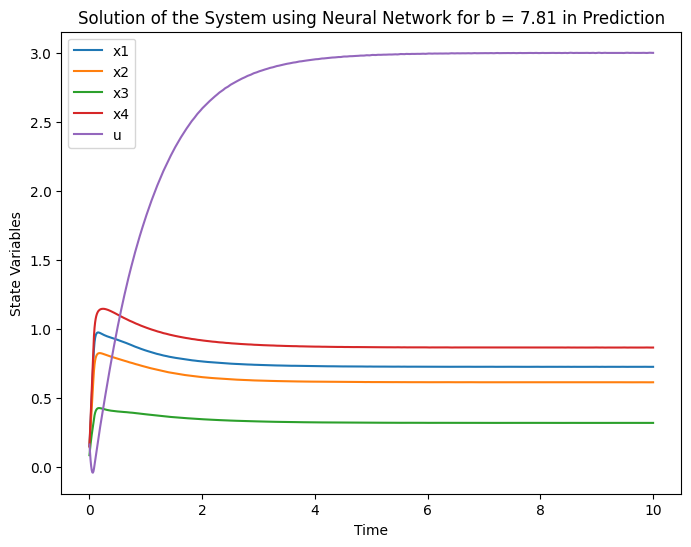

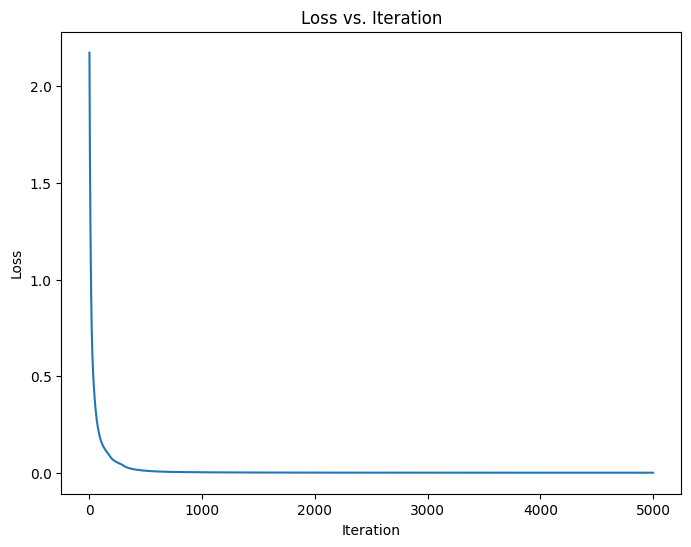

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Define the system of differential equations with variable b
def system(t, y, b):
    x1, x2, x3, x4, u = y
    dydt = [
        -(-9.54 + max(3.18 * (u + 3.18 * x1 + 2.72 * x2 + 1.42 * x3 + 3.81 * x4 - b), 0)),
        -(-8.16 + max(2.72 * (u + 3.18 * x1 + 2.72 * x2 + 1.42 * x3 + 3.81 * x4 - b), 0)),
        -(-4.26 + max(1.42 * (u + 3.18 * x1 + 2.72 * x2 + 1.42 * x3 + 3.81 * x4 - b), 0)),
        -(-11.43 + max(3.81 * (u + 3.18 * x1 + 2.72 * x2 + 1.42 * x3 + 3.81 * x4 - b), 0)),
        max((u + 3.18 * x1 + 2.72 * x2 + 1.42 * x3 + 3.81 * x4 - b), 0) - u
    ]
    return dydt

# Define the PINN loss function
def pinn_loss(y_true, y_pred):
    # Extract states and their derivatives
    x, x_dot = y_true[:, :5], y_true[:, 5:]

    # Predicted states and derivatives from the neural network
    x_pred, x_dot_pred = y_pred[:, :5], y_pred[:, 5:]

    # Residuals of the differential equations for states
    residuals_states = x - x_pred

    # Check if x_dot_pred is empty
    if x_dot_pred.shape[1] == 0:
        mse_residuals_states = tf.reduce_mean(tf.square(residuals_states))
        return mse_residuals_states

    # Residuals of the differential equations for derivatives
    residuals_derivatives = x_dot - x_dot_pred

    # Ensure that the dimensions are consistent
    x_dot_pred = tf.expand_dims(x_dot_pred, axis=-1)

    # Mean squared error for the residuals
    mse_residuals_states = tf.reduce_mean(tf.square(residuals_states))
    mse_residuals_derivatives = tf.reduce_mean(tf.square(residuals_derivatives))

    return mse_residuals_states + mse_residuals_derivatives


# Function to generate data with a probability distribution for b
def generate_data_pinns(num_samples, mean_b, std_dev_b, is_training=True):
    # Set initial conditions and time span
    initial_condition = [0, 0, 0, 0, 0]
    t_span = (0, 10)

    # Generate random values of b from a normal distribution
    b_values = np.random.normal(loc=mean_b, scale=std_dev_b, size=num_samples)

    # Initialize arrays to store data
    X_data_pinns = []
    y_data_pinns = []

    for b_value in b_values:
        # Generate data using solve_ivp
        sol_pinns = solve_ivp(system, t_span, initial_condition, args=(b_value,), method='RK45', dense_output=True)
        t_values_pinns = np.linspace(0, 10, 1000)
        y_values_pinns = sol_pinns.sol(t_values_pinns)

        # Extract the input (X_data_pinns) and target (y_data_pinns) data
        X_data_pinns.append(np.hstack([y_values_pinns.T[:-1, :], np.full((999, 1), b_value)]))  # Use states and b as input
        y_data_pinns.append(np.hstack([y_values_pinns.T[1:, :5], y_values_pinns.T[:-1, :]]))    # Use derivatives and states as target

    X_data_pinns = np.vstack(X_data_pinns)
    y_data_pinns = np.vstack(y_data_pinns)

    return X_data_pinns, y_data_pinns

# Define the neural network architecture with two hidden layers
model = Sequential([
    Dense(100, activation='tanh', input_shape=(6,)),
    Dense(10, activation='tanh'),
    Dense(5)  # Output layer with 5 nodes for derivatives
])

# Compile the model with the PINN loss function and a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=pinn_loss)

# Generate training data with a probability distribution for b and additional data for PINNs
num_samples_train = 1000
mean_b_train = 5.0
std_dev_b_train = 2.0
X_train, y_train = generate_data_pinns(num_samples_train, mean_b_train, std_dev_b_train)

# Train the model
history = model.fit(X_train, y_train, epochs=5000, batch_size=len(X_train), verbose=1)

# Generate testing data with a probability distribution for b
num_samples_test = 500
mean_b_test = 5.0  # You can change this value
std_dev_b_test = 2.0  # You can change this value
X_test, y_test = generate_data_pinns(num_samples_test, mean_b_test, std_dev_b_test, is_training=False)

# Evaluate the model on the testing data
test_loss = model.evaluate(X_test, y_test)
print(f"\nTest Loss for b distribution: {test_loss}")

# Make predictions for b = 7.81
b_value_to_predict = 7.81
X_predict, y_predict = generate_data_pinns(1, b_value_to_predict, 0, is_training=False)

# Use the trained model to predict the system's response
predicted_states = model.predict(X_predict)

# Print the final values for the predicted b value
final_values_predict = predicted_states[-1]
print(f"\nFinal values for b={b_value_to_predict:.2f} in prediction:")
print(f"x1: {final_values_predict[0]}")
print(f"x2: {final_values_predict[1]}")
print(f"x3: {final_values_predict[2]}")
print(f"x4: {final_values_predict[3]}")
print(f"u: {final_values_predict[4]}")

# Plot the results for the predicted b value
t_values_visualize = np.linspace(0, 10, 999)  # Adjust the length to match the data
plt.figure(figsize=(8, 6))
plt.plot(t_values_visualize, predicted_states[:, 0], label='x1')
plt.plot(t_values_visualize, predicted_states[:, 1], label='x2')
plt.plot(t_values_visualize, predicted_states[:, 2], label='x3')
plt.plot(t_values_visualize, predicted_states[:, 3], label='x4')
plt.plot(t_values_visualize, predicted_states[:, 4], label='u')
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend()
plt.title(f'Solution of the System using Neural Network for b = {b_value_to_predict:.2f} in Prediction')
plt.show()

# Plot loss vs. iteration
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.show()
